In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
import pickle
import os
import keras_tuner as kt
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print(tf.config.list_physical_devices('GPU'))
import matplotlib.pyplot as plt

[]


In [7]:
rank = 'master'
with open(f'data/matches/{rank}.ds', 'rb') as f:
    training_data = pickle.load(f)

In [8]:
train_x, train_y = (training_data[0][:-1000], training_data[1][:-1000])
test_x, test_y = (training_data[0][-1000:], training_data[1][-1000:])

In [9]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(train_x)

In [18]:
def model_builder(hp):
    model = keras.Sequential()
    
    model.add(normalizer)
    
    for i in range(hp.Int('num_layers', 2, 14, step=1)):
        model.add(layers.Dense(
            units=hp.Int('units_' + str(i), 32, 512, step=8),
            kernel_initializer=hp.Choice('kernel_init_' + str(i), ['lecun_normal', 'lecun_uniform', 'he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal']),
            kernel_regularizer=regularizers.l2(0.001),
            bias_initializer='zeros',
            activation=hp.Choice('activation_' + str(i), ['relu', 'elu', 'selu', 'sigmoid'])))
        if i % 3 == 0:
            model.add(layers.Dropout(hp.Float('dropout_' + str(i), 0.1, 0.8, sampling='linear')))
            model.add(layers.BatchNormalization())
    model.add(layers.Dense(1))
    
    optimizer=optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 1e-4]))
    loss=losses.BinaryCrossentropy(from_logits=True)
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[keras.metrics.BinaryAccuracy()])
    return model

In [20]:
tuner = kt.tuners.RandomSearch(
    model_builder,
    objective='val_binary_accuracy',
    max_trials=100,
    executions_per_trial=30,
    directory='kt_models',
    project_name='winpredictor'
)
tuner.search_space_summary()

Search space summary
Default search space size: 9
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 14, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 8, 'sampling': 'linear'}
kernel_init_0 (Choice)
{'default': 'lecun_normal', 'conditions': [], 'values': ['lecun_normal', 'lecun_uniform', 'he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'], 'ordered': False}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'selu', 'sigmoid'], 'ordered': False}
dropout_0 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.8, 'step': None, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 8, 'sampling': 'linear'}
kernel_init_1 (Choice)
{'default': 'lecun_normal', 'conditions': [], 'values': ['lecun_normal', 'lecun_uniform', 'he_uniform', 'he_normal', 'glorot_unif

In [7]:
tuner.search(train_x[:10000], train_y[:10000], batch_size=8, validation_split=0.1)

Trial 40 Complete [00h 00m 22s]
val_binary_accuracy: 0.593999981880188

Best val_binary_accuracy So Far: 0.6899999856948853
Total elapsed time: 00h 14m 25s
INFO:tensorflow:Oracle triggered exit


In [12]:
history = model.fit(train_x, train_y, validation_split=0.1, batch_size=32, epochs=20)

Epoch 1/20
2901/2901 [==============================] - 6s 2ms/step - loss: 1.0508 - binary_accuracy: 0.5153 - val_loss: 0.9378 - val_binary_accuracy: 0.5324
Epoch 2/20
2901/2901 [==============================] - 5s 2ms/step - loss: 0.8802 - binary_accuracy: 0.5153 - val_loss: 0.8337 - val_binary_accuracy: 0.5324
Epoch 3/20
2901/2901 [==============================] - 5s 2ms/step - loss: 0.8149 - binary_accuracy: 0.5173 - val_loss: 0.7750 - val_binary_accuracy: 0.5346
Epoch 4/20
2901/2901 [==============================] - 6s 2ms/step - loss: 0.7692 - binary_accuracy: 0.5607 - val_loss: 0.7312 - val_binary_accuracy: 0.6701
Epoch 5/20
2901/2901 [==============================] - 6s 2ms/step - loss: 0.7331 - binary_accuracy: 0.6302 - val_loss: 0.7010 - val_binary_accuracy: 0.7047
Epoch 6/20
2901/2901 [==============================] - 6s 2ms/step - loss: 0.7068 - binary_accuracy: 0.6719 - val_loss: 0.6830 - val_binary_accuracy: 0.7116
Epoch 7/20
2901/2901 [==============================

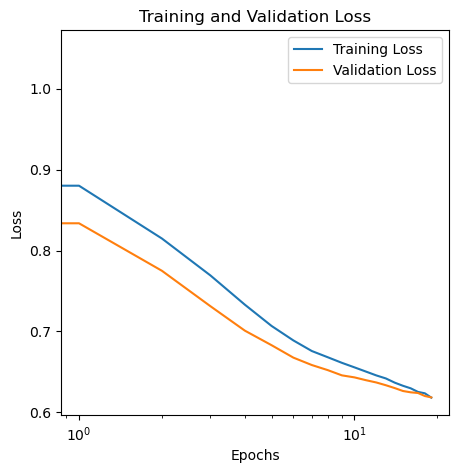

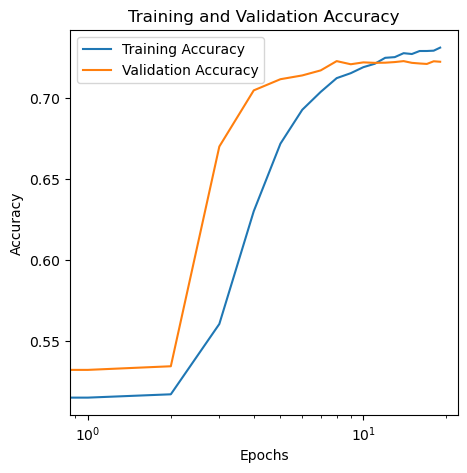

In [13]:
history_dic = history.history
history_dic.keys()

plt.figure(figsize=(5, 5))
plt.plot(history_dic['loss'], label='Training Loss')
plt.plot(history_dic['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(history_dic['binary_accuracy'], label='Training Accuracy')
plt.plot(history_dic['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.xscale('log')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
loss, accuracy = model.evaluate(test_x, test_y)
print('Loss:', loss)
print('Accuracy:', accuracy)

32/32 [==============================] - 0s 839us/step - loss: 0.6760 - binary_accuracy: 0.6780
Loss: 0.6760279536247253
Accuracy: 0.6779999732971191


In [24]:
export_model = keras.Sequential([
    model,
    layers.Activation('sigmoid')
])
export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)
export_model.save('live-model.h5')